very loosely based on https://keras.io/examples/vision/mnist_convnet/

In [ ]:
outdim=1

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
bx_train = np.expand_dims(x_train, -1)
bx_test = np.expand_dims(x_test, -1)
print("x_train shape:", bx_train.shape)
print(bx_train.shape[0], "train samples")
print(bx_test.shape[0], "test samples")


# convert class vectors to binary class matrices
by_train = keras.utils.to_categorical(y_train, num_classes)
by_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
classes=[0,1]
x_train=np.array(
    [xx for xx,yy in zip(bx_train,by_train) if
      np.any([yy[cc] for cc in classes])
    ])
y_train=np.array([yy for yy in by_train if np.any([yy[cc] for cc in classes])])
print(x_train.shape)
print(y_train.shape)

xa_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      not np.any([yy[cc] for cc in classes])
    ])
ya_test=np.array([yy for yy in by_test if not np.any([yy[cc] for cc in classes])])
print(xa_test.shape)
print(ya_test.shape)
xn_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      np.any([yy[cc] for cc in classes])
    ])
yn_test=np.array([yy for yy in by_test if np.any([yy[cc] for cc in classes])])
print(xn_test.shape)
print(yn_test.shape)



(12665, 28, 28, 1)
(12665, 10)
(7885, 28, 28, 1)
(7885, 10)
(2115, 28, 28, 1)
(2115, 10)


In [ ]:
def loss(outdim):
    if outdim==1:
        def lss(a,b):
            q=b
            return K.mean((q-1)**2)
        return lss
    def lss(a,b):
        q=b
        pd=[i for i in range(len(q.shape))]
        pd.remove(pd[-1])
        pd.insert(0,len(pd))
        #print(pd)
        q=K.permute_dimensions(q,tuple(pd))
        #exit()

        #print(q.shape)

        adl=None

        for i in range(outdim):
            for j in range(i+1,outdim):
              ac=K.abs(K.mean(((q[i]-1)*(q[j]-1))))
              if adl is None:
                  adl=ac
              else:
                  adl+=ac

        return adl
    return lss

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(16, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(4, kernel_size=(2, 2), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(4,kernel_size=(1,1),activation="linear",padding="same",use_bias=False),
        layers.Flatten(),
        layers.Dense(outdim,use_bias=False)
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 16)          16384     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 4)           256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 4)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 4)           1

In [ ]:
batch_size = 128
epochs = 5

model.compile(loss=loss(outdim), optimizer="adam", metrics=[])

model.fit(x_train,
          np.ones_like(x_train),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Epoch 1/5
90/90 [==============================] - 13s 131ms/step - loss: 0.1254 - val_loss: 0.0027
Epoch 2/5
90/90 [==============================] - 11s 128ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/5
90/90 [==============================] - 12s 129ms/step - loss: 0.0010 - val_loss: 8.4112e-04
Epoch 4/5
90/90 [==============================] - 11s 128ms/step - loss: 8.4382e-04 - val_loss: 0.0010
Epoch 5/5
90/90 [==============================] - 11s 127ms/step - loss: 7.6114e-04 - val_loss: 6.7457e-04


In [ ]:
pa=model.predict(xa_test)
pn=model.predict(xn_test)

In [ ]:
print(pa.shape)
print(pn.shape)

(7885, 1)
(2115, 1)


In [ ]:
da=np.abs(pa-1)
dn=np.abs(pn-1)
dfa=np.sqrt(np.mean(da**2,axis=1))
dfn=np.sqrt(np.mean(dn**2,axis=1))
print(dfa.shape,dfn.shape)

(7885,) (2115,)


In [ ]:
print("normal",np.mean(dfn),np.std(dfn))
print("abnorm",np.mean(dfa),np.std(dfa))

normal 0.018976478 0.020292003
abnorm 0.032145835 0.029660605


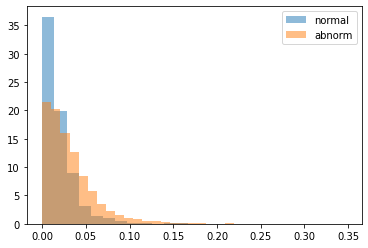

In [ ]:
import matplotlib.pyplot as plt

plt.hist(dfn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(dfa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

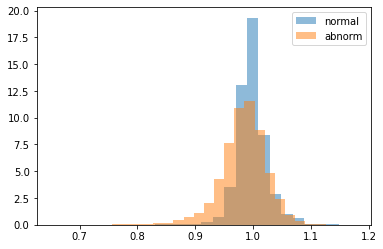

In [ ]:
plt.hist(pn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(pa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
def dexbyloss(lss):return np.argmin(np.mean((pn-lss)**2,axis=1))
minl=np.min(pn,axis=0)
maxl=np.max(pn,axis=0)
print(minl,maxl)
ls=[np.arange(aminl,amaxl,(amaxl-aminl)/9.0001) for aminl,amaxl in zip(minl,maxl)]
print(minl,ls,maxl)
print(len(ls))

[0.6517416] [1.148728]
[0.6517416] [array([0.65174162, 0.70696172, 0.76218182, 0.81740191, 0.87262201,
       0.92784211, 0.9830622 , 1.0382823 , 1.09350239, 1.14872249])] [1.148728]
1


In [ ]:
dex=np.array([dexbyloss(l0) for l0 in ls[0]])
print(dex)

[1370 1370 1379 1379  646  772  146 1464  613  333]


In [ ]:
topl=np.array([[xn_test[d] for d in dex]])
print(topl.shape)


(1, 10, 28, 28, 1)


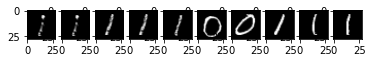

In [ ]:
for i,zx in enumerate(topl):
  for j,zw in enumerate(zx):

    plt.subplot(len(topl),len(zx),1+len(zx)*i+j)
    plt.imshow(zw[:,:,0], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
td=np.array([np.argmax(yn_test[d]) for d in dex])
print(td)

[1 1 1 1 1 0 0 1 1 1]


In [ ]:
p=model.predict(x_train)


In [ ]:
mp=np.mean(p,axis=0)
da=np.abs(pa-mp)
dn=np.abs(pn-mp)
dfa=np.sqrt(np.mean(da**2,axis=1))
dfn=np.sqrt(np.mean(dn**2,axis=1))
print(dfa.shape,dfn.shape)

(7885,) (2115,)


In [ ]:
print("normal",np.mean(dfn),np.std(dfn))
print("abnorm",np.mean(dfa),np.std(dfa))

normal 0.018849088 0.020321868
abnorm 0.031691078 0.029361466


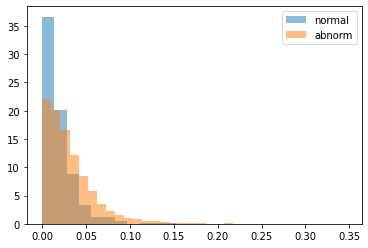

In [ ]:
plt.hist(dfn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(dfa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
y_score=np.concatenate((dfn,dfa),axis=0)
y_true=np.concatenate((np.zeros_like(dfn),np.ones_like(dfa)),axis=0)

print(y_true.shape,y_score.shape)

(10000,) (10000,)


In [ ]:
from sklearn.metrics import roc_auc_score as rauc

auc=rauc(y_true,y_score)
print(auc)

0.6560880326082231
